In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import random 
import time
from itertools import combinations
import nltk
from transformers import BertTokenizer, BertModel
import numpy as np
from collections import Counter
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Name Scraping

In [15]:
ponzi2 = pd.read_csv("Ponzi_label.csv")
ponzi2 = ponzi2[ponzi2['Ponzi']=='1']['Contract'].tolist()
ponzi3 = pd.read_csv("PonziDataset_20221114.csv")
ponzi3=ponzi3[['address','label']]
ponzi3=ponzi3[ponzi3['label']==1]['address'].tolist()
ponzi_addresses = list(set(ponzi2+ponzi3))

In [29]:
ponzi_names = []
addresses_seen = []
for address in tqdm(ponzi_addresses):
    # URL of the page to scrape
    url = "https://etherscan.io/address/"+str(address).strip()

    # Set headers to make the request look like it's coming from a browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    # Send a GET request to the URL with headers and get the page HTML content
    try:
        response = requests.get(url, headers=headers)
        html_content = response.content

        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(html_content, "html.parser")
        ponzi_name = soup.find("head").find("title").text.strip()
        ponzi_name = ponzi_name[:ponzi_name.find("|")].strip()
        checks = ponzi_name.split()[-1]
        if checks == str(address).strip():
            ponzi_name = None
        ponzi_names.append(ponzi_name)
        addresses_seen.append(address)
        time.sleep(random.random()*5 + 3)
        df = pd.DataFrame({'address':addresses_seen, 'name':ponzi_names})
        df.to_csv("address_to_name1.csv", index=False)

    except:
        df = pd.DataFrame({'address':addresses_seen, 'name':ponzi_names})
        df.to_csv("address_to_name1.csv", index=False)
        print("Current address:", address)
        time.sleep(60+random.random()*30)


100%|██████████| 436/436 [45:23<00:00,  6.25s/it]


In [36]:
#Opening and merging the different data
nonponzi1 = pd.read_csv("Ponzi_label.csv")
nonponzi1 = nonponzi1[nonponzi1['Ponzi']=='0']['Contract'].tolist()
nonponzi2 = pd.read_csv("PonziDataset_20221114.csv")
nonponzi2=nonponzi2[['address','label']]
nonponzi2=nonponzi2[nonponzi2['label']==0]['address'].tolist()
nonponzi_addresses = list(set(nonponzi1+nonponzi2))
len(nonponzi_addresses)

7046

In [37]:
non_ponzi_names = []
addresses_seen = []
for address in tqdm(nonponzi_addresses):
    # URL of the page to scrape
    url = "https://etherscan.io/address/"+str(address).strip()

    # Set headers to make the request look like it's coming from a browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    # Send a GET request to the URL with headers and get the page HTML content
    try:
        response = requests.get(url, headers=headers)
        html_content = response.content

        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(html_content, "html.parser")
        non_ponzi_name = soup.find("head").find("title").text.strip()
        non_ponzi_name = non_ponzi_name[:non_ponzi_name.find("|")].strip()
        checks = non_ponzi_name.split()[-1]
        if checks == str(address).strip():
            non_ponzi_name = None
        non_ponzi_names.append(non_ponzi_name)
        addresses_seen.append(address)
        time.sleep(random.random()*5 + 3)
        df = pd.DataFrame({'address':addresses_seen, 'name':non_ponzi_names})
        df.to_csv("address_to_name_np.csv", index=False)

    except:
        df = pd.DataFrame({'address':addresses_seen, 'name':non_ponzi_names})
        df.to_csv("address_to_name_np.csv", index=False)
        print("Current address:", address)
        time.sleep(60+random.random()*30)


 32%|███▏      | 2285/7046 [4:00:26<8:25:09,  6.37s/it] 

Current address: 0xb939ef33629bba211688724e401d4f6400c0ee6a


 41%|████▏     | 2920/7046 [5:11:17<7:53:06,  6.88s/it] 

Current address: 0x67499A8bCdd401eE18c1F8A62C903EDbc1883954


100%|██████████| 7046/7046 [12:42:44<00:00,  6.50s/it]  


## Name Analysis

In [2]:
ponzi_contracts = pd.read_csv("address_to_name.csv")
ponzi_contracts =ponzi_contracts.iloc[:-35,:] #dropping unnamed contracts
ponzi_contracts=ponzi_contracts['name'].tolist()

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3, outside=False):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(15,7))
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('hsv') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
  
      
    # plot in 2 dimensions
    if dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
        if outside:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
        else:
            plt.legend()

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.show()

In [4]:
import re
import inflect
engine = inflect.engine()
cleaned_names = []
for i in tqdm(range(len(ponzi_contracts))):
    current_name = ponzi_contracts[i]
    current_name = current_name.replace('_', '')
    current_name = current_name.replace('-', '')
    current_name = re.sub("\d+", "", current_name) #remove numbers
    current_name= re.sub(r"^\w", lambda match: match.group().upper(), current_name)
    words = re.findall('([A-Z][a-z]+)', current_name)
    if len(words)>0:
        for j in range(len(words)):
            singular = engine.singular_noun(words[j])
            if singular != False:
                words[j] = singular
        cleaned_names.append(' '.join(words))
    else:
        cleaned_names.append(current_name)

100%|██████████| 394/394 [00:00<00:00, 2675.42it/s]


In [5]:
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

def is_english_word(word):
    return word.lower() in english_vocab

def all_combinations(my_list):
    words = []
    for i in range(len(my_list)+1):
        for combination in combinations(my_list, i):
            combination=''.join(combination)
            if is_english_word(combination) or combination == 'ponzi' or combination=='eth':
                if len(combination)>=3 and combination!='poi':
                    words.append(combination)
    if len(words)==0:
        return [''.join(my_list)]
    return words

In [6]:
# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
ponzi_embeddings = []
for contract in tqdm(cleaned_names): 
    encoded_input = tokenizer(contract, return_tensors='pt')
    input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())

    tokens_seen = []
    tokens_generated = tokenizer.tokenize(contract)
    tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
    tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
    tokens_seen+=all_combinations(tokens_generated)


    # Convert the tokens to BERT input format
    inputs = tokenizer.encode_plus(
        tokens_seen,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Generate the BERT embeddings
    outputs = model(**inputs)
    embeddings = outputs[0][0]
    ponzi_embeddings.append(embeddings.mean(dim=0).detach().numpy())
ponzi_embeddings = np.array(ponzi_embeddings)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 394/394 [00:27<00:00, 14.49it/s]


c:\Users\fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


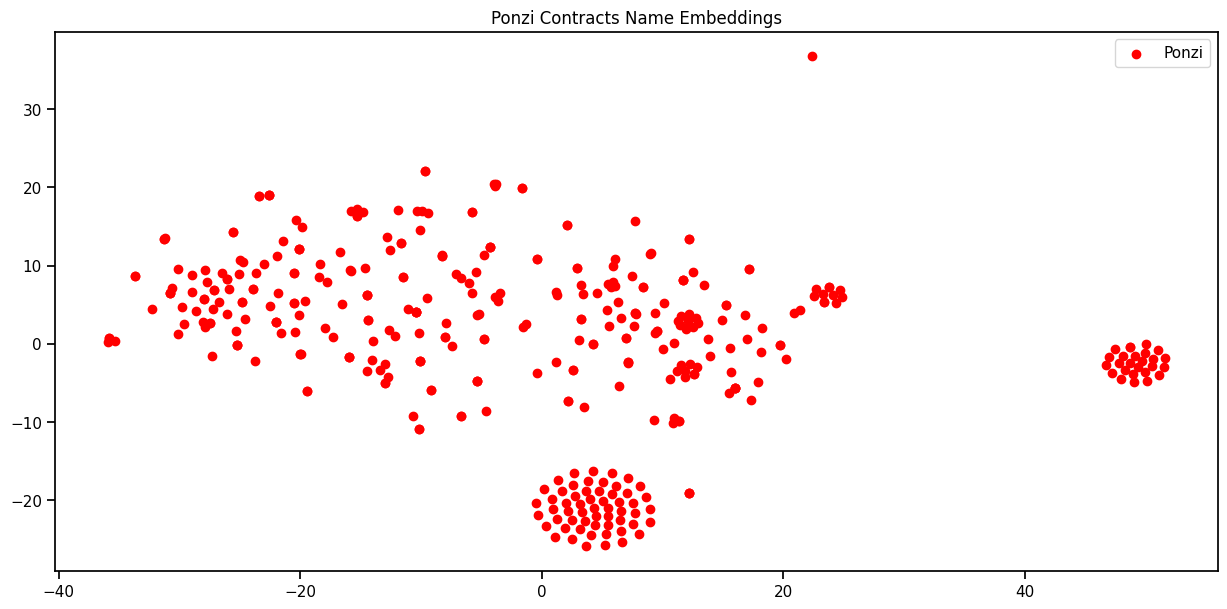

In [7]:
from sklearn.manifold import TSNE
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Ponzi Contracts Name Embeddings')
tsne=TSNE(n_components=2, random_state=2, n_jobs=-1, learning_rate='auto').fit_transform(ponzi_embeddings)
ax.scatter(tsne[:,0], tsne[:,1], color = 'red', label='Ponzi')
plt.legend()
plt.show()

#### K-means

In [8]:
silhouettes = []
calinski = []
davies=[]
K = range(2, 40)

for c in tqdm(K):
    clustering_model = KMeans(n_clusters=c,init='k-means++', max_iter = 1500)
    clustering_model.fit(ponzi_embeddings)
    silhouettes.append(silhouette_score(ponzi_embeddings, clustering_model.labels_))
    calinski.append(calinski_harabasz_score(ponzi_embeddings, clustering_model.labels_))
    davies.append(davies_bouldin_score(ponzi_embeddings, clustering_model.labels_))

100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


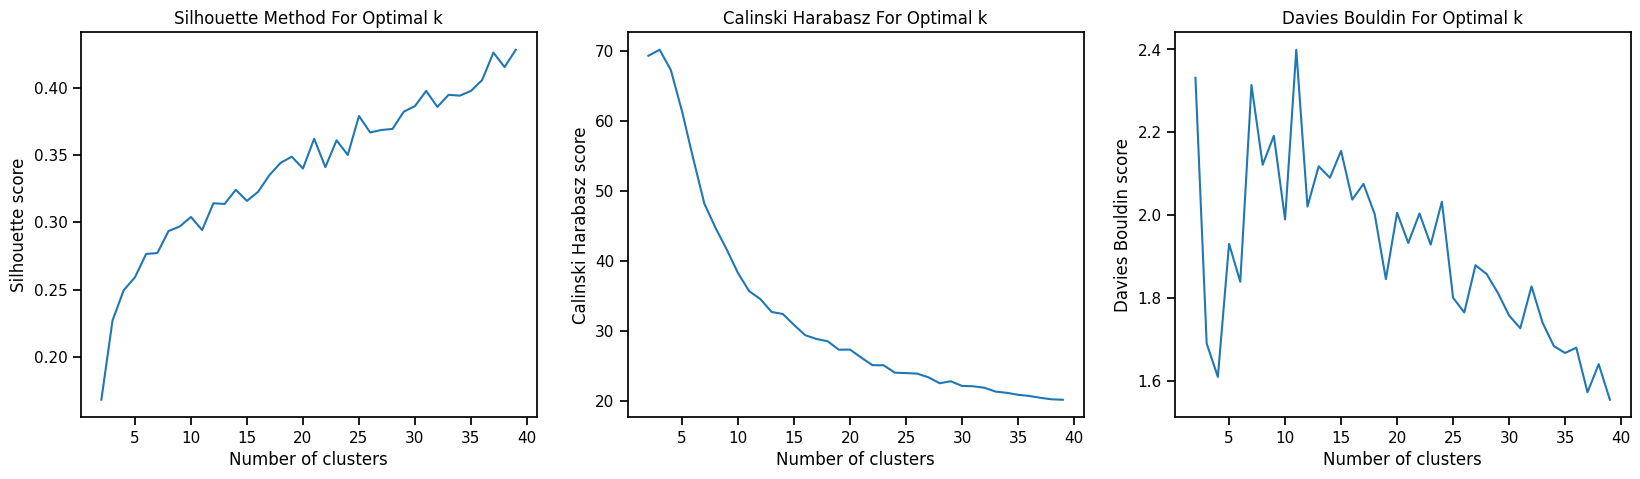

In [9]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,5))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, calinski)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski Harabasz score')
ax.set_title('Calinski Harabasz For Optimal k')

ax=axs[2]
ax.plot(K, davies)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies Bouldin score')
ax.set_title('Davies Bouldin For Optimal k')

plt.show()

In [10]:
clusters=5
model=KMeans(n_clusters=clusters, init='k-means++', max_iter=5000, random_state=1)
model.fit(ponzi_embeddings)

KMeans(max_iter=5000, n_clusters=5, random_state=1)

In [11]:
preds = model.predict(ponzi_embeddings)
cleaned_names = np.array(cleaned_names)
for i in range(clusters):
    tokens_seen = []
    for contract in cleaned_names[np.where(preds==i)]: #some ponzis had the same names
        encoded_input = tokenizer(contract, return_tensors='pt')
        input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())
        tokens_generated = tokenizer.tokenize(contract)
        tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
        tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
        tokens_seen+=all_combinations(tokens_generated)
    print(f'Cluster {i}:', Counter(tokens_seen).most_common(6))

Cluster 0: [('tran', 26), ('che', 26), ('eth', 26)]
Cluster 1: [('the', 15), ('ether', 15), ('game', 11), ('pyramid', 11), ('token', 6), ('redistribution', 6)]
Cluster 2: [('pyramid', 61), ('eth', 58), ('ponzi', 2), ('shadow', 1), ('square', 1), ('root', 1)]
Cluster 3: [('coin', 7), ('five', 6), ('forty', 5), ('factory', 4), ('x', 4), ('just', 4)]
Cluster 4: [('ponzi', 62), ('doubler', 13), ('eth', 12), ('double', 12), ('token', 10), ('reset', 9)]


In [26]:
a = np.array(ponzi_contracts)
a[np.where(preds==0)]

array(['EthTranchePricing', 'EthTranchePricing', 'EthTranchePricing',
       'EthTranchePricing', 'EthTranchePricing', 'EthTranchePricing',
       'EthTranchePricing', 'EthTranchePricing', 'EthTranchePricing',
       'EthTranchePricing', 'EthTranchePricing', 'EthTranchePricing',
       'EthTranchePricing', 'EthTranchePricing', 'EthTranchePricing',
       'EthTranchePricing', 'EthTranchePricing', 'EthTranchePricing',
       'EthTranchePricing', 'EthTranchePricing', 'EthTranchePricing',
       'EthTranchePricing', 'EthTranchePricing', 'EthTranchePricing',
       'EthTranchePricing', 'EthTranchePricing'], dtype='<U29')

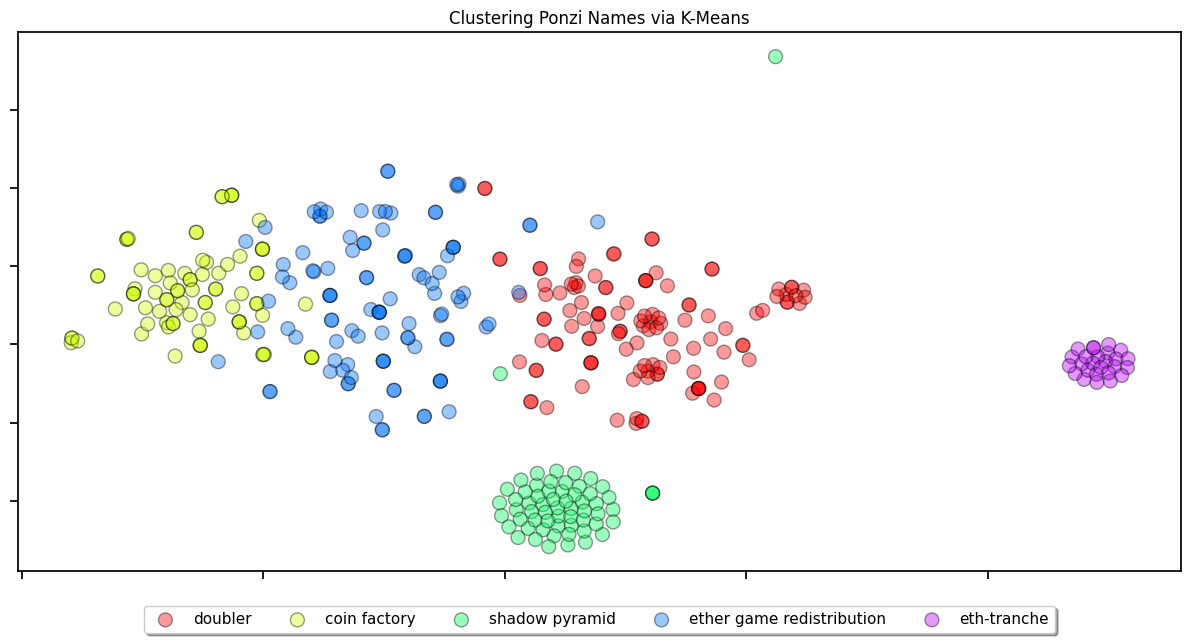

In [207]:
labels = ['eth-tranche', 'ether game redistribution','shadow pyramid','coin factory', 'doubler']
labels_graph = [labels[i] for i in model.labels_]
plot_vectors(tsne, 'Clustering Ponzi Names via K-Means', labels_graph, dimensions=2, outside=True)

#### Hierarchical Clustering

In [91]:
silhouettes = []
calinski = []
davies=[]

for c in tqdm(range(2, 40)):
    clustering_model =  AgglomerativeClustering(n_clusters=c)
    clustering_model.fit(ponzi_embeddings)
    silhouettes.append(silhouette_score(ponzi_embeddings, clustering_model.labels_))
    calinski.append(calinski_harabasz_score(ponzi_embeddings, clustering_model.labels_))
    davies.append(davies_bouldin_score(ponzi_embeddings, clustering_model.labels_))

100%|██████████| 38/38 [00:02<00:00, 15.52it/s]


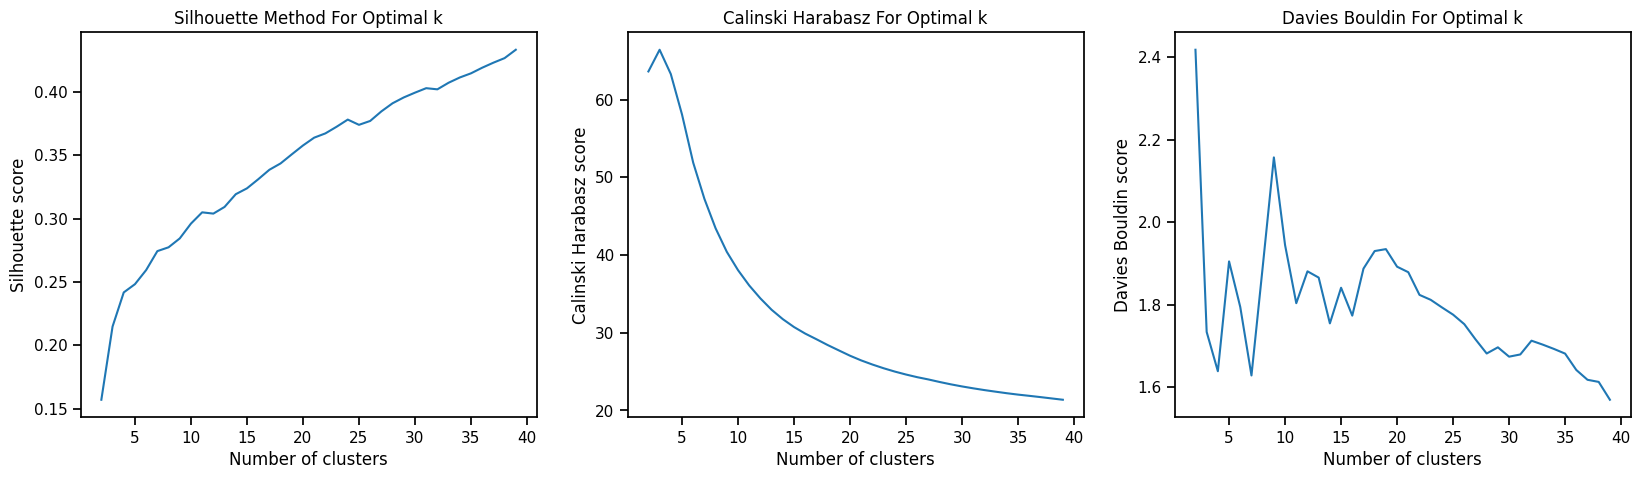

In [94]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,5))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, calinski)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski Harabasz score')
ax.set_title('Calinski Harabasz For Optimal k')

ax=axs[2]
ax.plot(K, davies)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies Bouldin score')
ax.set_title('Davies Bouldin For Optimal k')

plt.show()

In [95]:
clusters=5
model=AgglomerativeClustering(n_clusters=clusters)
model.fit(ponzi_embeddings)

AgglomerativeClustering(n_clusters=5)

In [97]:
preds = model.fit_predict(ponzi_embeddings)
for i in range(clusters):
    tokens_seen = []
    for contract in cleaned_names[np.where(preds==i)]: #some ponzis had the same names
        encoded_input = tokenizer(contract, return_tensors='pt')
        input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())
        tokens_generated = tokenizer.tokenize(contract)
        tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
        tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
        tokens_seen+=all_combinations(tokens_generated)
    print(f'Cluster {i}:', Counter(tokens_seen).most_common(6))

Cluster 0: [('factory', 4), ('x', 4), ('ponzi', 4), ('peer', 4), ('babylon', 3), ('open', 3)]
Cluster 1: [('ether', 18), ('the', 17), ('pyramid', 14), ('game', 13), ('ponzi', 8), ('coin', 8)]
Cluster 2: [('tran', 26), ('che', 26), ('eth', 26)]
Cluster 3: [('pyramid', 60), ('eth', 57), ('ponzi', 2), ('square', 1), ('root', 1), ('bipyramid', 1)]
Cluster 4: [('ponzi', 52), ('eth', 13), ('doubler', 13), ('double', 12), ('token', 10), ('reset', 9)]


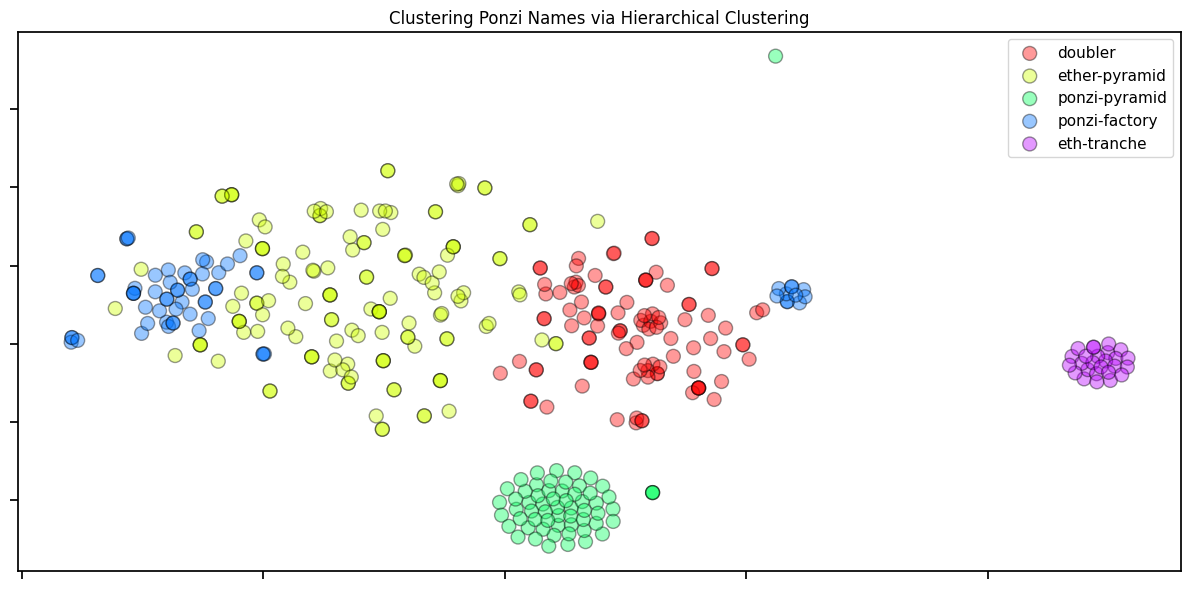

In [98]:
labels = ['ponzi-factory', 'ether-pyramid','eth-tranche','ponzi-pyramid','doubler']
labels_graph = [labels[i] for i in model.labels_]
plot_vectors(tsne, 'Clustering Ponzi Names via Hierarchical Clustering', labels_graph, dimensions=2)

### BayesianGaussianMixture

In [99]:
from sklearn.mixture import BayesianGaussianMixture

silhouettes = []
calinski = []
davies=[]

for c in tqdm(range(2, 39)):
    clustering_model =  BayesianGaussianMixture(n_components=c, random_state=1)
    preds = clustering_model.fit_predict(ponzi_embeddings)

    silhouettes.append(silhouette_score(ponzi_embeddings, preds))
    calinski.append(calinski_harabasz_score(ponzi_embeddings, preds))
    davies.append(davies_bouldin_score(ponzi_embeddings, preds))

100%|██████████| 37/37 [02:35<00:00,  4.20s/it]


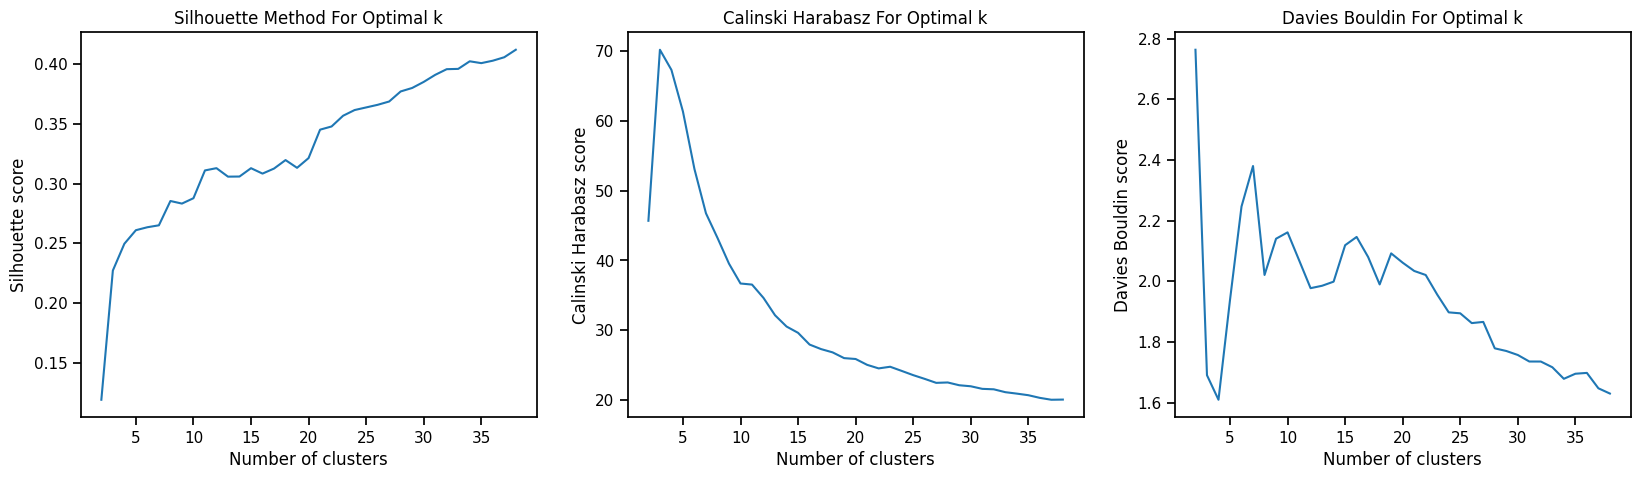

In [101]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,5))
clusts = np.arange(2,39)
ax=axs[0]
ax.plot(clusts, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(clusts, calinski)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski Harabasz score')
ax.set_title('Calinski Harabasz For Optimal k')

ax=axs[2]
ax.plot(clusts, davies)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies Bouldin score')
ax.set_title('Davies Bouldin For Optimal k')

plt.show()

In [102]:
clusters=5
model= BayesianGaussianMixture(n_components=clusters, random_state=1, n_init=10)
model.fit(ponzi_embeddings)

BayesianGaussianMixture(n_components=5, n_init=10, random_state=1)

In [103]:
preds = model.predict(ponzi_embeddings)
for i in range(clusters):
    tokens_seen = []
    for contract in cleaned_names[np.where(preds==i)]: #some ponzis had the same names
        encoded_input = tokenizer(contract, return_tensors='pt')
        input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())
        tokens_generated = tokenizer.tokenize(contract)
        tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
        tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
        tokens_seen+=all_combinations(tokens_generated)
    print(f'Cluster {i}:', Counter(tokens_seen).most_common(6))

Cluster 0: [('pyramid', 61), ('eth', 58), ('ponzi', 2), ('shadow', 1), ('square', 1), ('root', 1)]
Cluster 1: [('tran', 26), ('che', 26), ('eth', 26)]
Cluster 2: [('ponzi', 57), ('doubler', 13), ('double', 12), ('token', 10), ('eth', 10), ('reset', 9)]
Cluster 3: [('ponzi', 4), ('pixiu', 2), ('eth', 1), ('plier', 1), ('multiplier', 1), ('ply', 1)]
Cluster 4: [('ether', 18), ('the', 15), ('pyramid', 14), ('game', 11), ('coin', 8), ('five', 7)]


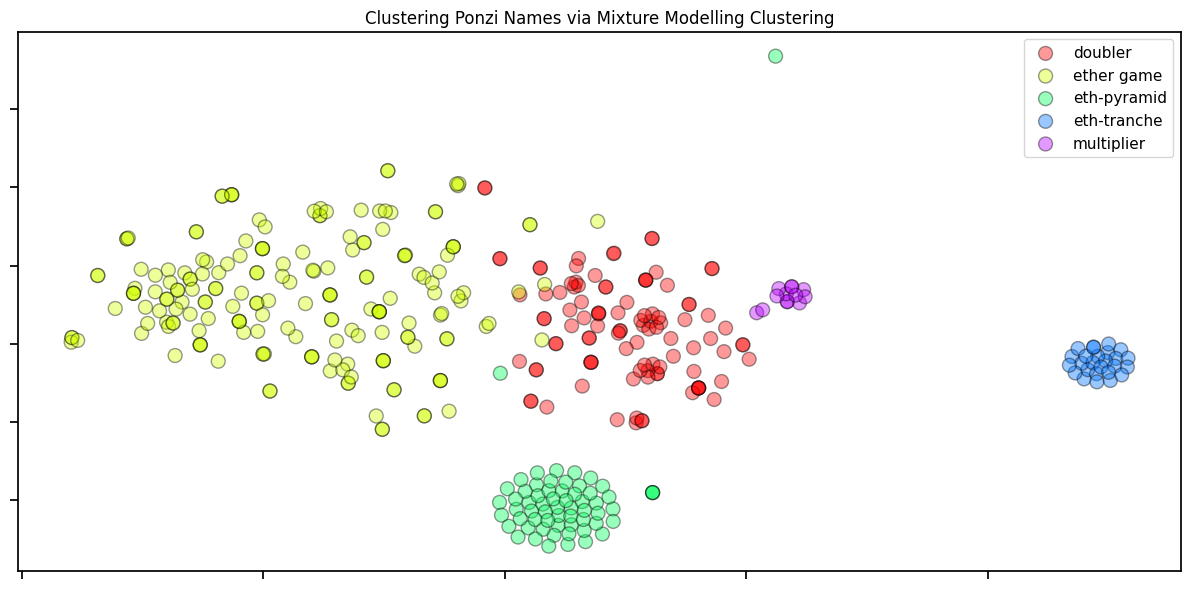

In [104]:
labels = ['eth-pyramid','eth-tranche','doubler', 'multiplier', 'ether game']
labels_graph = [labels[i] for i in preds]
plot_vectors(tsne, 'Clustering Ponzi Names via Mixture Modelling Clustering', labels_graph, dimensions=2)

## Introducing Non-Ponzi

In [2]:
non_ponzi = pd.read_csv("address_to_name_np.csv")
non_ponzi['address']=non_ponzi['address'].str.lower()
non_ponzi = non_ponzi.drop_duplicates(subset='address')
non_ponzi_names = non_ponzi['name'].astype(str).tolist()

In [3]:
import re
import inflect
engine = inflect.engine()
cleaned_names_non_ponzi = []
for i in tqdm(range(len(non_ponzi_names))):
    current_word=non_ponzi_names[i]
    current_word = current_word.replace('_', '')
    current_word = current_word.replace('-', '')
    current_word = re.sub("\d+", "", current_word) #remove numbers
    current_word= re.sub(r"^\w", lambda match: match.group().upper(), current_word)
    words = re.findall('([A-Z][a-z]+)', current_word)
    if len(words)>0:
        for j in range(len(words)):
            singular = engine.singular_noun(words[j])
            if singular != False:
                words[j] = singular
        cleaned_names_non_ponzi.append(' '.join(words))
    else:
        cleaned_names_non_ponzi.append(current_word)

100%|██████████| 6187/6187 [00:01<00:00, 5556.59it/s]


In [6]:
import torch
from transformers import BertTokenizer, BertModel

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
nonponzi_embeddings = []
for contract in tqdm(cleaned_names_non_ponzi):
    encoded_input = tokenizer(contract, return_tensors='pt')
    input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())

    tokens_seen = []
    tokens_generated = tokenizer.tokenize(contract)
    tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
    tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
    tokens_seen+=all_combinations(tokens_generated)


    # Convert the tokens to BERT input format
    inputs = tokenizer.encode_plus(
        tokens_seen,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Generate the BERT embeddings
    outputs = model(**inputs)
    embeddings = outputs[0][0]
    nonponzi_embeddings.append(embeddings.mean(dim=0).detach().numpy())
nonponzi_embeddings = np.array(nonponzi_embeddings)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 6187/6187 [06:15<00:00, 16.47it/s]


c:\Users\fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


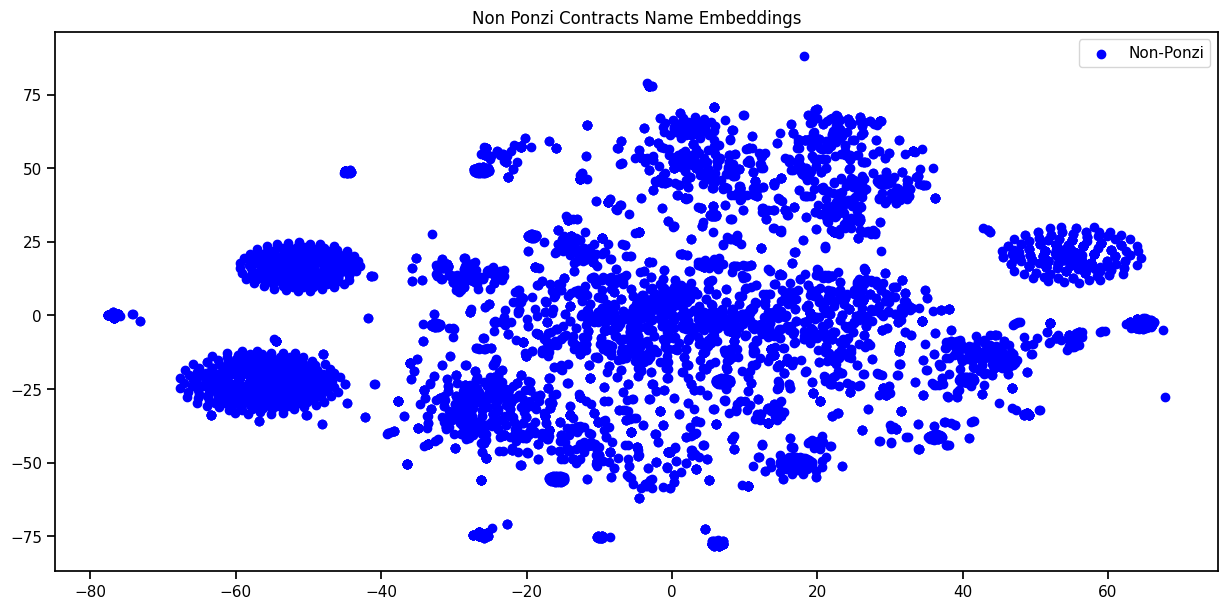

In [30]:
from sklearn.manifold import TSNE
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Non Ponzi Contracts Name Embeddings')
tsne=TSNE(n_components=2, random_state=2, n_jobs=-1, learning_rate='auto').fit_transform(nonponzi_embeddings)
ax.scatter(tsne[:,0], tsne[:,1], color = 'blue', label='Non-Ponzi')
plt.legend()
plt.show()

### K-Means

In [109]:
silhouettes = []
calinski = []
davies=[]
K = range(2, 40)

for c in tqdm(K):
    clustering_model = KMeans(n_clusters=c,init='k-means++', max_iter = 1500)
    clustering_model.fit(nonponzi_embeddings)
    silhouettes.append(silhouette_score(nonponzi_embeddings, clustering_model.labels_))
    calinski.append(calinski_harabasz_score(nonponzi_embeddings, clustering_model.labels_))
    davies.append(davies_bouldin_score(nonponzi_embeddings, clustering_model.labels_))

100%|██████████| 38/38 [06:25<00:00, 10.15s/it]


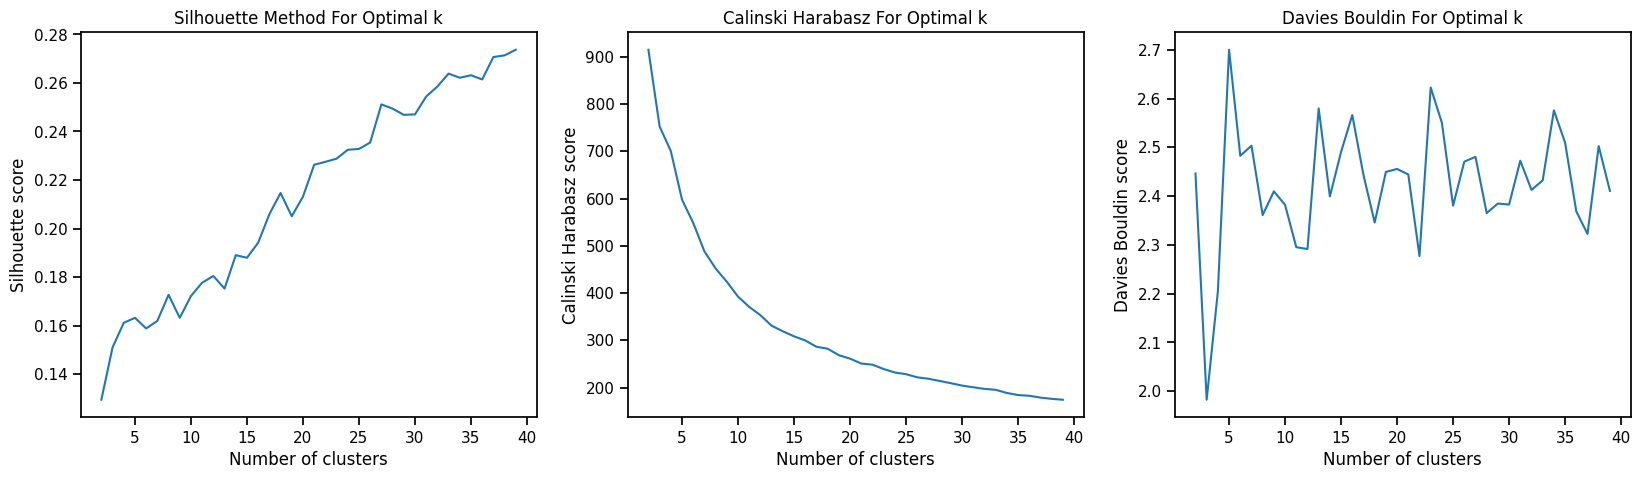

In [110]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,5))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, calinski)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski Harabasz score')
ax.set_title('Calinski Harabasz For Optimal k')

ax=axs[2]
ax.plot(K, davies)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies Bouldin score')
ax.set_title('Davies Bouldin For Optimal k')

plt.show()

In [31]:
clusters=4
model=KMeans(n_clusters=clusters, init='k-means++', max_iter=5000, random_state=1)
model.fit(nonponzi_embeddings)

KMeans(max_iter=5000, n_clusters=4, random_state=1)

In [32]:
preds = model.predict(nonponzi_embeddings)
cleaned_names_non_ponzi = np.array(cleaned_names_non_ponzi)
for i in range(clusters):
    tokens_seen = []
    for contract in cleaned_names_non_ponzi[np.where(preds==i)]: #some ponzis had the same names
        encoded_input = tokenizer(contract, return_tensors='pt')
        input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())
        tokens_generated = tokenizer.tokenize(contract)
        tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
        tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
        tokens_seen+=all_combinations(tokens_generated)
    print(f'Cluster {i}:', Counter(tokens_seen).most_common(6))

Cluster 0: [('token', 447), ('ale', 299), ('coin', 105), ('withdraw', 53), ('die', 49), ('sale', 49)]
Cluster 1: [('token', 1047), ('sale', 391), ('coin', 281), ('ale', 155), ('sal', 137), ('ether', 134)]
Cluster 2: [('token', 317), ('sig', 151), ('wallet', 139), ('ale', 109), ('sale', 107), ('eth', 89)]
Cluster 3: [('ethraffle', 13), ('ico', 11), ('iou', 10), ('sig', 10), ('ule', 7), ('hodl', 6)]


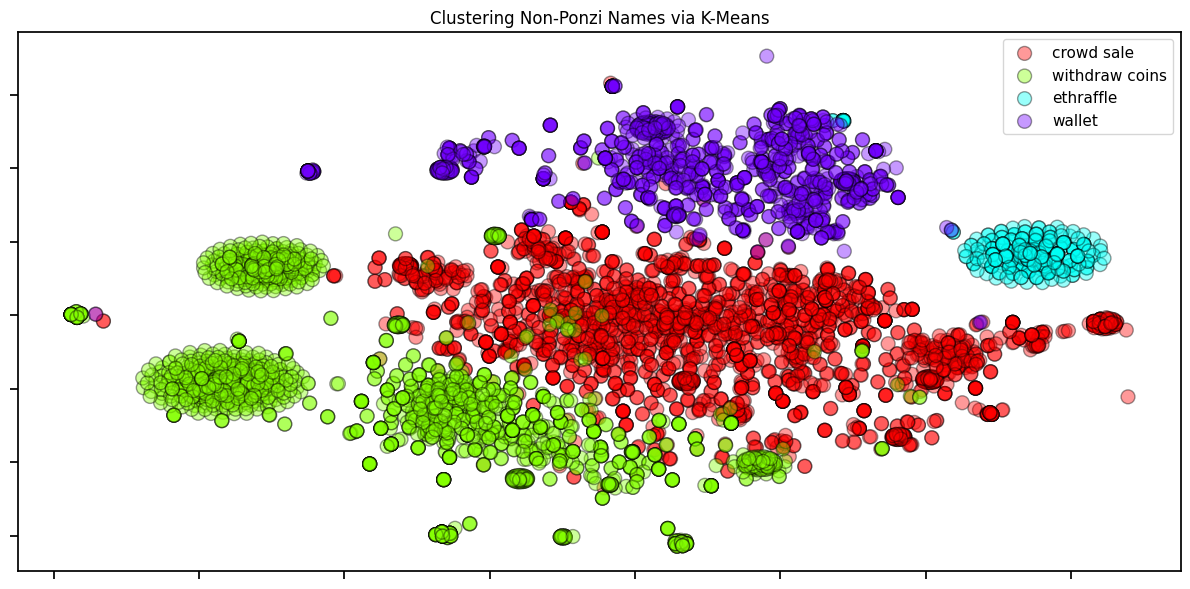

In [34]:
labels = ['withdraw coins', 'crowd sale','wallet','ethraffle']
labels_graph = [labels[i] for i in model.labels_]
plot_vectors(tsne, 'Clustering Non-Ponzi Names via K-Means', labels_graph, dimensions=2)

### Hierarchical Clustering

In [9]:
silhouettes = []
calinski = []
davies=[]

for c in tqdm(range(2, 40)):
    clustering_model =  AgglomerativeClustering(n_clusters=c)
    clustering_model.fit(nonponzi_embeddings)
    silhouettes.append(silhouette_score(nonponzi_embeddings, clustering_model.labels_))
    calinski.append(calinski_harabasz_score(nonponzi_embeddings, clustering_model.labels_))
    davies.append(davies_bouldin_score(nonponzi_embeddings, clustering_model.labels_))

100%|██████████| 38/38 [07:37<00:00, 12.03s/it]


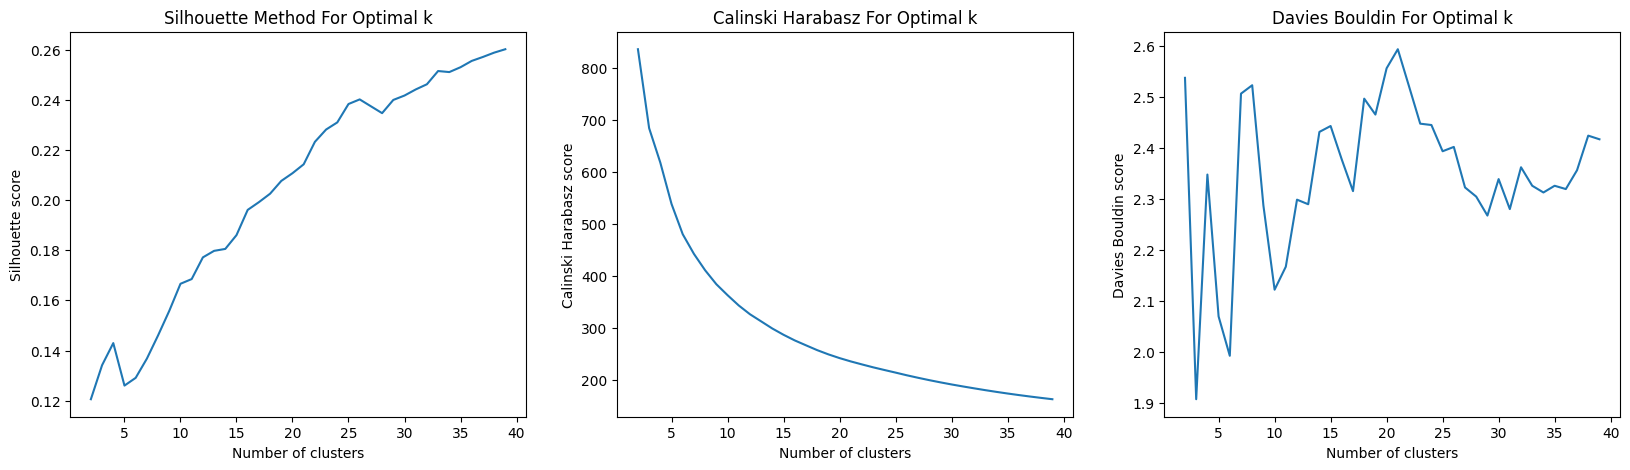

In [11]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,5))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, calinski)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski Harabasz score')
ax.set_title('Calinski Harabasz For Optimal k')

ax=axs[2]
ax.plot(K, davies)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies Bouldin score')
ax.set_title('Davies Bouldin For Optimal k')

plt.show()

In [12]:
clusters=8
model=AgglomerativeClustering(n_clusters=clusters)
model.fit(nonponzi_embeddings)

AgglomerativeClustering(n_clusters=8)

In [17]:
preds = model.fit_predict(nonponzi_embeddings)
cleaned_names_non_ponzi =np.array(cleaned_names_non_ponzi)
for i in range(clusters):
    tokens_seen = []
    for contract in cleaned_names_non_ponzi[np.where(preds==i)]: #some ponzis had the same names
        encoded_input = tokenizer(contract, return_tensors='pt')
        input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())
        tokens_generated = tokenizer.tokenize(contract)
        tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
        tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
        tokens_seen+=all_combinations(tokens_generated)
    print(f'Cluster {i}:', Counter(tokens_seen).most_common(6))

Cluster 0: [('ale', 229), ('token', 110), ('sale', 77), ('sal', 75), ('mint', 73), ('capped', 69)]
Cluster 1: [('coin', 104), ('withdraw', 53), ('sale', 52), ('die', 49), ('contest', 45), ('fund', 39)]
Cluster 2: [('token', 823), ('sale', 187), ('coin', 154), ('advanced', 44), ('factory', 39), ('ether', 35)]
Cluster 3: [('token', 253), ('sale', 165), ('sig', 148), ('wallet', 135), ('sal', 112), ('coin', 85)]
Cluster 4: [('ale', 295)]
Cluster 5: [('token', 435)]
Cluster 6: [('ethraffle', 13), ('ico', 11), ('iou', 10), ('sig', 7), ('hodl', 6), ('dao', 6)]
Cluster 7: [('token', 180), ('ether', 145), ('coin', 105), ('sale', 66), ('proxy', 62), ('buyer', 62)]


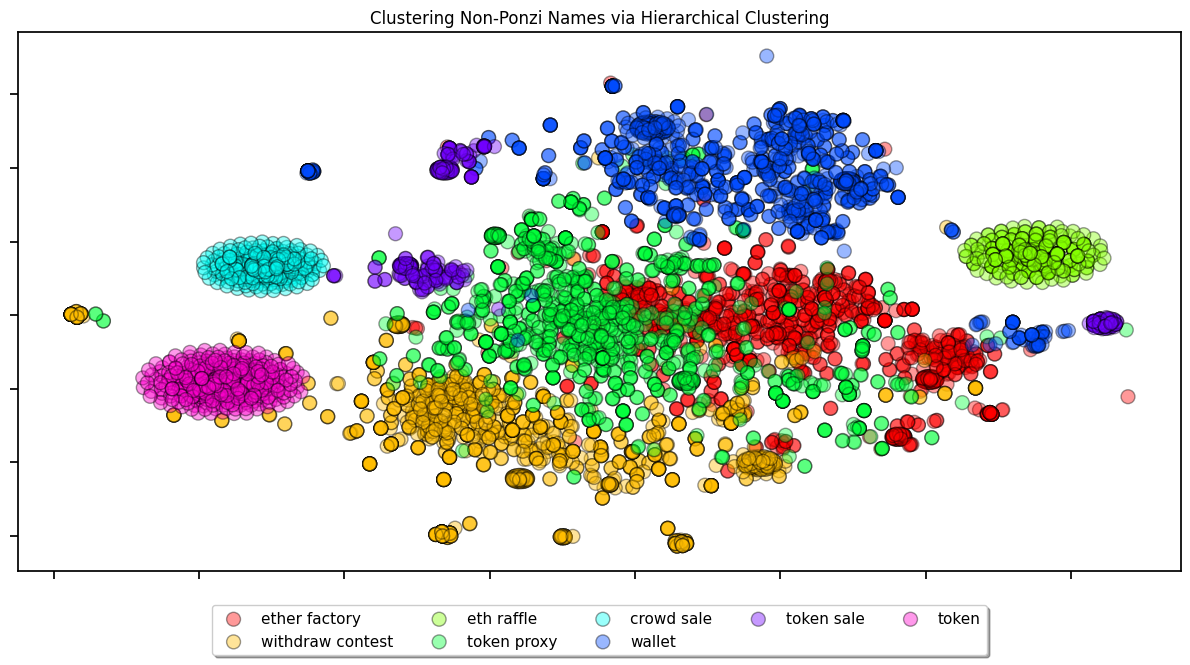

In [20]:
labels = [ 'token sale','withdraw contest','ether factory','wallet','crowd sale', 'token', 'eth raffle', 'token proxy']
labels_graph = [labels[i] for i in model.labels_]
plot_vectors(tsne, 'Clustering Non-Ponzi Names via Hierarchical Clustering', labels_graph, dimensions=2, outside=True)

### BayesianGaussianMixture

In [149]:
from sklearn.mixture import BayesianGaussianMixture

silhouettes = []
calinski = []
davies=[]

for c in tqdm(range(2, 40)):
    clustering_model =  BayesianGaussianMixture(n_components=c, random_state=1)
    preds = clustering_model.fit_predict(nonponzi_embeddings)

    silhouettes.append(silhouette_score(nonponzi_embeddings, preds))
    calinski.append(calinski_harabasz_score(nonponzi_embeddings, preds))
    davies.append(davies_bouldin_score(nonponzi_embeddings, preds))

100%|██████████| 38/38 [16:33<00:00, 26.14s/it]


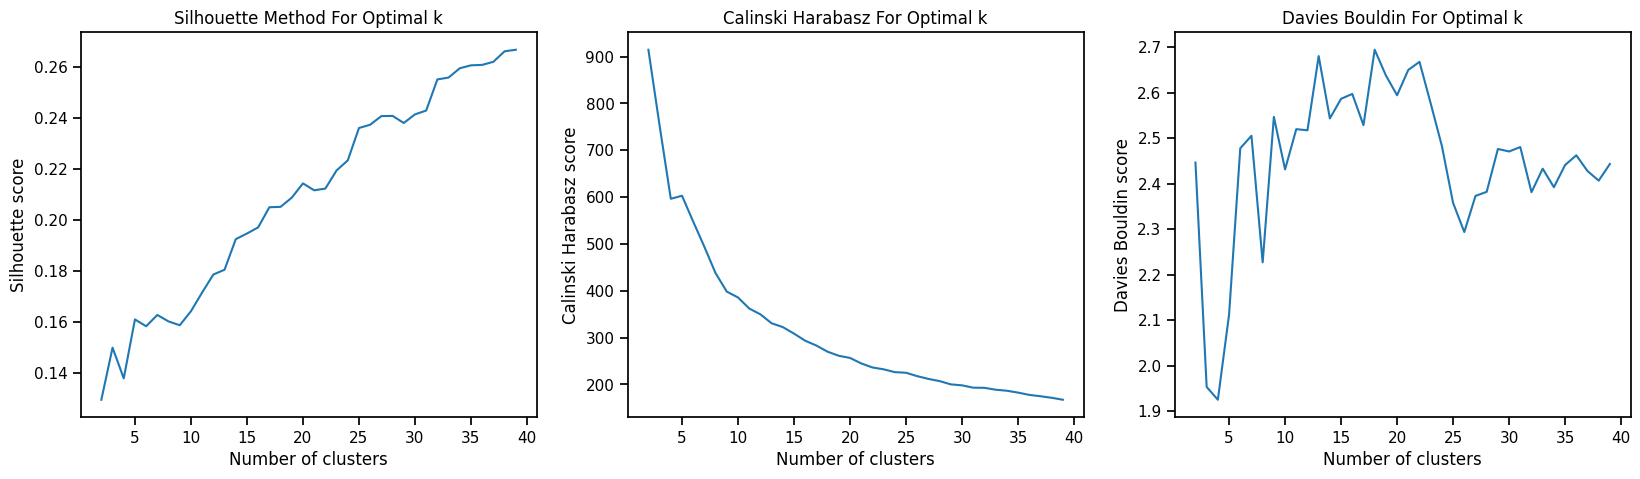

In [151]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,5))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, calinski)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski Harabasz score')
ax.set_title('Calinski Harabasz For Optimal k')

ax=axs[2]
ax.plot(K, davies)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies Bouldin score')
ax.set_title('Davies Bouldin For Optimal k')

plt.show()

In [160]:
clusters=6
model= BayesianGaussianMixture(n_components=clusters, random_state=1, n_init=10)
model.fit(nonponzi_embeddings)

BayesianGaussianMixture(n_components=6, n_init=10, random_state=1)

In [161]:
preds = model.fit_predict(nonponzi_embeddings)
for i in range(clusters):
    tokens_seen = []
    for contract in cleaned_names_non_ponzi[np.where(preds==i)]: #some ponzis had the same names
        encoded_input = tokenizer(contract, return_tensors='pt')
        input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())
        tokens_generated = tokenizer.tokenize(contract)
        tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
        tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
        tokens_seen+=all_combinations(tokens_generated)
    print(f'Cluster {i}:', Counter(tokens_seen).most_common(6))

Cluster 0: [('ale', 240), ('token', 111), ('mint', 73), ('capped', 69), ('tokened', 49), ('coin', 19)]
Cluster 1: [('withdraw', 53), ('voting', 11), ('sal', 11), ('token', 10), ('registrar', 10), ('private', 10)]
Cluster 2: [('token', 973), ('sale', 373), ('coin', 231), ('sal', 132), ('ether', 123), ('buyer', 71)]
Cluster 3: [('token', 435), ('ale', 295), ('die', 49), ('ethraffle', 13), ('ico', 11), ('iou', 10)]
Cluster 4: [('token', 257), ('sig', 154), ('wallet', 138), ('sale', 107), ('coin', 76), ('eth', 74)]
Cluster 5: [('coin', 131), ('sale', 53), ('contest', 45), ('ether', 44), ('wallet', 37), ('issue', 30)]


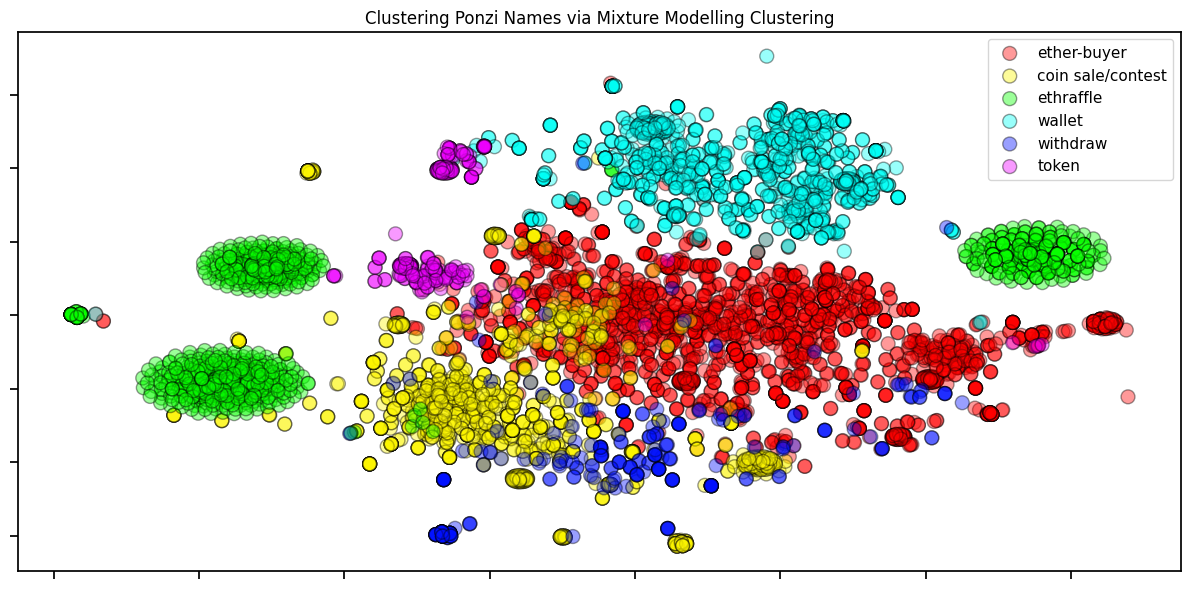

In [163]:
labels = ['token', 'withdraw', 'ether-buyer', 'ethraffle','wallet','coin sale/contest']
labels_graph = [labels[i] for i in preds]
plot_vectors(tsne, 'Clustering Ponzi Names via Mixture Modelling Clustering', labels_graph, dimensions=2)

## Comparing Ponzi and Non-Ponzi smart contracts

In [10]:
all_embeddings = np.concatenate([ponzi_embeddings, nonponzi_embeddings], axis=0)

c:\Users\fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


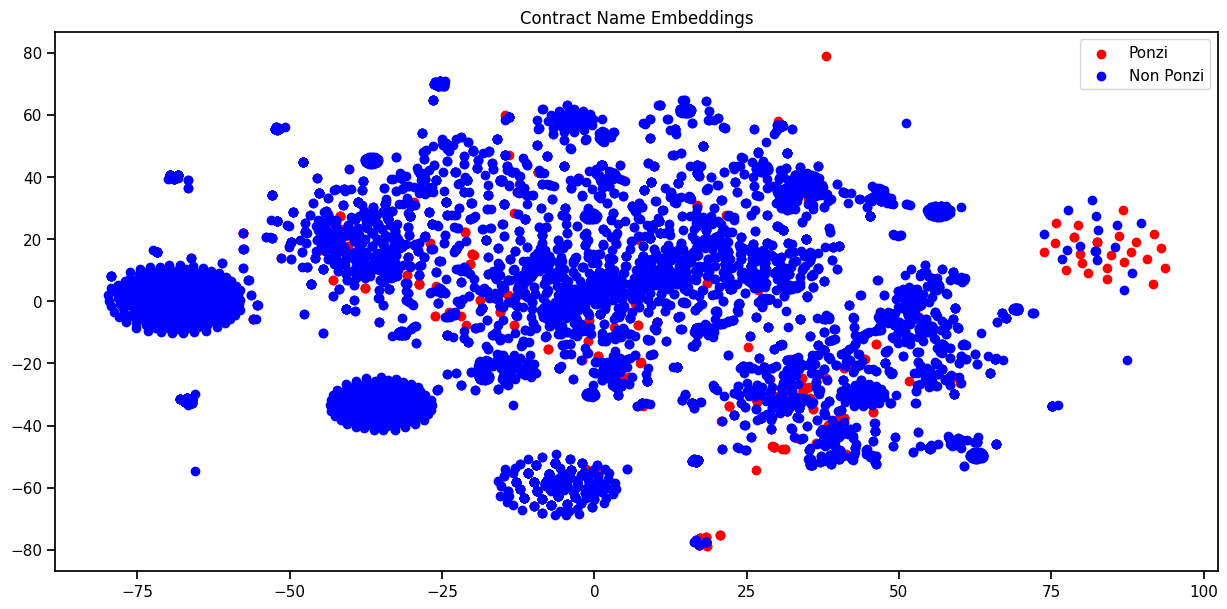

In [49]:
from sklearn.manifold import TSNE
fig, ax = plt.subplots(figsize=(15,7))
all_embeddings = np.concatenate([ponzi_embeddings, nonponzi_embeddings], axis=0)
tsne=TSNE(n_components=2, random_state=2, n_jobs=-1, learning_rate='auto').fit_transform(all_embeddings)

ax.scatter(tsne[:len(ponzi_embeddings),0], tsne[:len(ponzi_embeddings),1], color = 'red', label='Ponzi')
ax.scatter(tsne[len(ponzi_embeddings):,0], tsne[len(ponzi_embeddings):,1], color = 'blue', label='Non Ponzi')
ax.set_title('Contract Name Embeddings')
plt.legend()
plt.show()

### KMeans

In [165]:
silhouettes = []
calinski = []
davies=[]
K = range(2, 40)

for c in tqdm(K):
    clustering_model = KMeans(n_clusters=c,init='k-means++', max_iter = 1500)
    clustering_model.fit(all_embeddings)
    silhouettes.append(silhouette_score(all_embeddings, clustering_model.labels_))
    calinski.append(calinski_harabasz_score(all_embeddings, clustering_model.labels_))
    davies.append(davies_bouldin_score(all_embeddings, clustering_model.labels_))

100%|██████████| 38/38 [05:46<00:00,  9.11s/it]


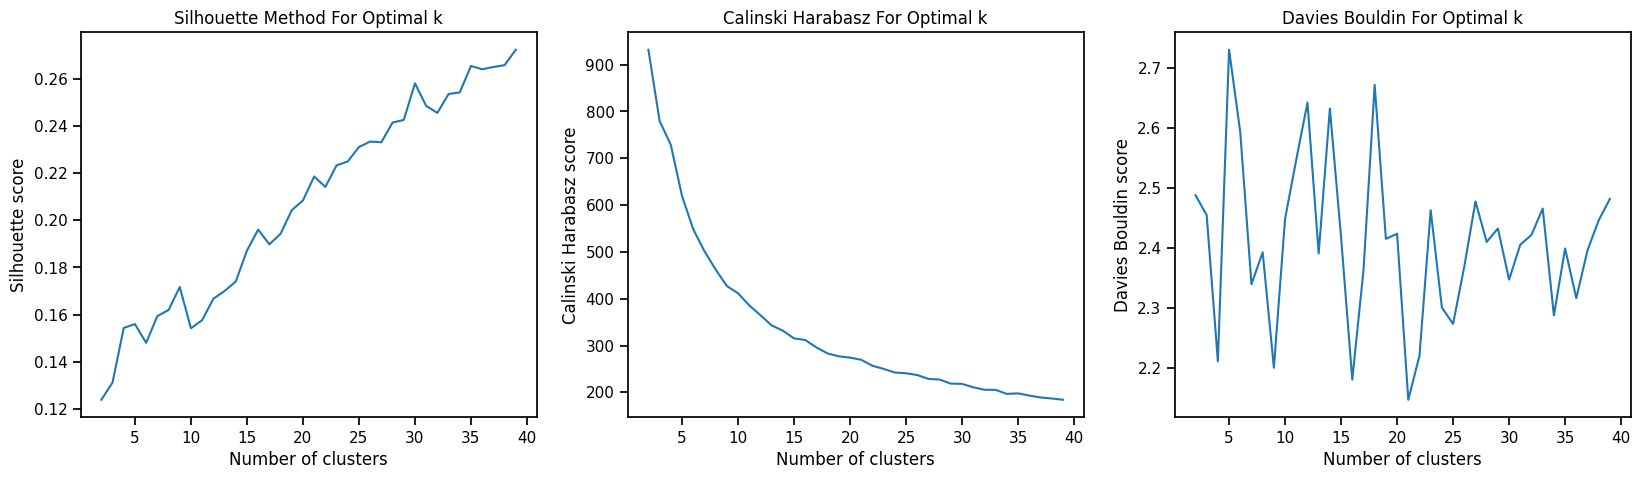

In [166]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,5))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, calinski)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski Harabasz score')
ax.set_title('Calinski Harabasz For Optimal k')

ax=axs[2]
ax.plot(K, davies)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies Bouldin score')
ax.set_title('Davies Bouldin For Optimal k')

plt.show()

In [171]:
clusters=5
model=KMeans(n_clusters=clusters, init='k-means++', max_iter=5000, random_state=1)
model.fit(all_embeddings)

KMeans(max_iter=5000, n_clusters=5, random_state=1)

In [172]:
preds = model.predict(all_embeddings)
all_contracts = np.concatenate([cleaned_names,np.array(cleaned_names_non_ponzi)], axis=0)

for i in range(clusters):
    tokens_seen_ponzi = []
    tokens_seen_nonponzi=[]
    for contract in all_contracts[np.where(preds==i)]:
        encoded_input = tokenizer(contract, return_tensors='pt')
        input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())
        tokens_generated = tokenizer.tokenize(contract)
        tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
        tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
        if contract in cleaned_names:
            tokens_seen_ponzi+=all_combinations(tokens_generated)
        else:
            tokens_seen_nonponzi+=all_combinations(tokens_generated)
    print('Cluster',i)
    print('Fraction Ponzi:',100*len(set(all_contracts[np.where(preds==i)]).intersection(set(cleaned_names))) / len(cleaned_names))
    print(Counter(tokens_seen_ponzi).most_common(6))
    print('Fraction Non-Ponzi:',100*len(set(all_contracts[np.where(preds==i)]).intersection(set(cleaned_names_non_ponzi))) / len(cleaned_names_non_ponzi))
    print(Counter(tokens_seen_nonponzi).most_common(6))

Cluster 0
Fraction Ponzi: 2.5380710659898478
[('ponzi', 4), ('ply', 2), ('multiply', 2), ('pixiu', 2), ('eth', 1), ('plier', 1)]
Fraction Non-Ponzi: 4.331663164700178
[('ethraffle', 13), ('ico', 11), ('iou', 10), ('sig', 10), ('ule', 7), ('hodl', 6)]
Cluster 1
Fraction Ponzi: 14.213197969543147
[('coin', 45), ('test', 14), ('pre', 14), ('factory', 12), ('slot', 9), ('five', 6)]
Fraction Non-Ponzi: 11.556489413285922
[('token', 448), ('coin', 67), ('withdraw', 53), ('die', 49), ('sale', 49), ('contest', 45)]
Cluster 2
Fraction Ponzi: 17.258883248730964
[('eth', 115), ('pyramid', 68), ('ponzi', 61), ('tran', 39), ('che', 39), ('doubler', 13)]
Fraction Non-Ponzi: 10.8129949894941
[('token', 317), ('sig', 151), ('wallet', 139), ('ale', 109), ('sale', 107), ('mint', 82)]
Cluster 3
Fraction Ponzi: 17.766497461928935
[('ether', 15), ('the', 13), ('game', 12), ('pyramid', 9), ('token', 9), ('redistribution', 9)]
Fraction Non-Ponzi: 26.103119443995475
[('token', 1001), ('sale', 389), ('coin', 2

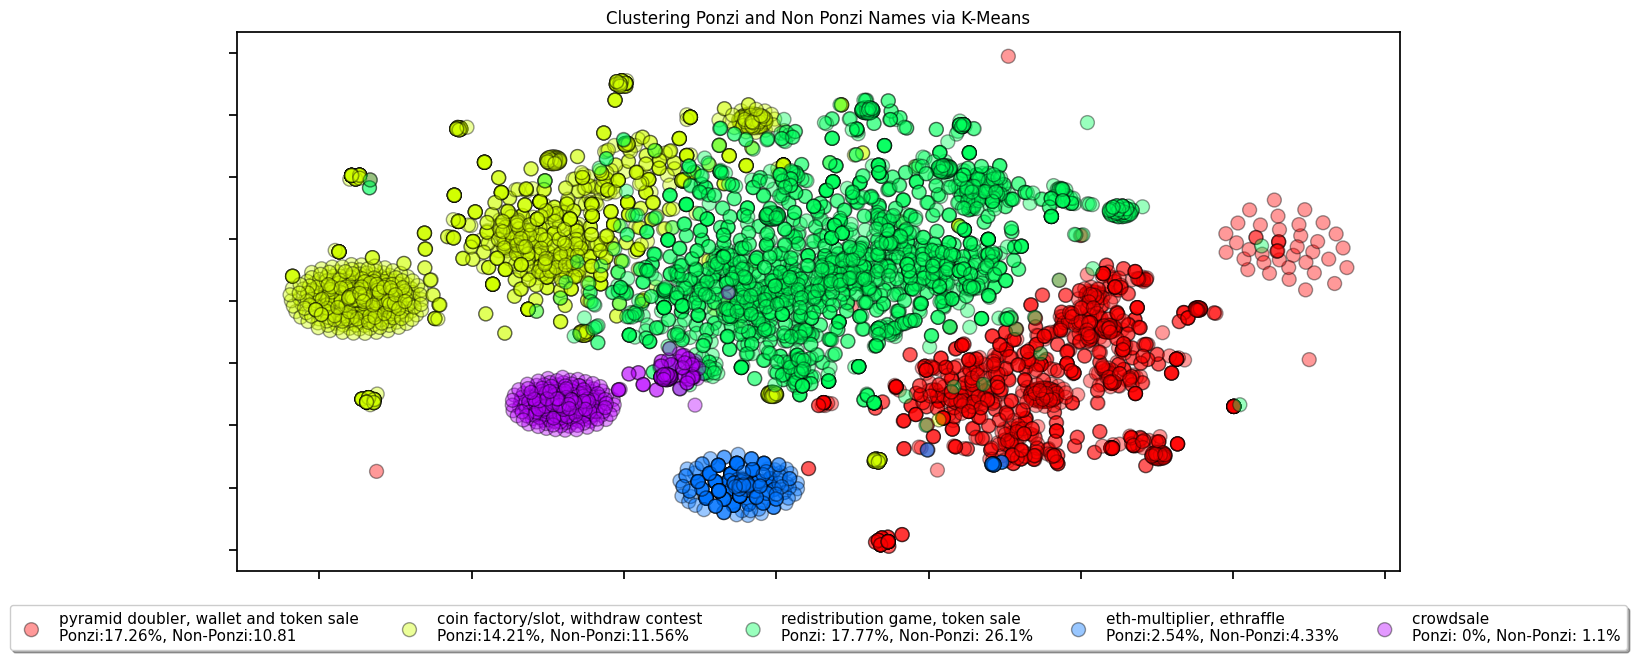

In [178]:
labels = ['eth-multiplier, ethraffle \nPonzi:2.54%, Non-Ponzi:4.33%', 
          'coin factory/slot, withdraw contest \nPonzi:14.21%, Non-Ponzi:11.56%',
          'pyramid doubler, wallet and token sale \nPonzi:17.26%, Non-Ponzi:10.81',
          'redistribution game, token sale \nPonzi: 17.77%, Non-Ponzi: 26.1%',
          'crowdsale \nPonzi: 0%, Non-Ponzi: 1.1%']
labels_graph = [labels[i] for i in model.labels_]
plot_vectors(tsne, 'Clustering Ponzi and Non Ponzi Names via K-Means', labels_graph, dimensions=2, outside=True)


### Hierarchical Clustering

In [179]:
silhouettes = []
calinski = []
davies=[]

for c in tqdm(range(2, 40)):
    clustering_model =  AgglomerativeClustering(n_clusters=c)
    clustering_model.fit(all_embeddings)
    silhouettes.append(silhouette_score(all_embeddings, clustering_model.labels_))
    calinski.append(calinski_harabasz_score(all_embeddings, clustering_model.labels_))
    davies.append(davies_bouldin_score(all_embeddings, clustering_model.labels_))

100%|██████████| 38/38 [08:45<00:00, 13.83s/it]


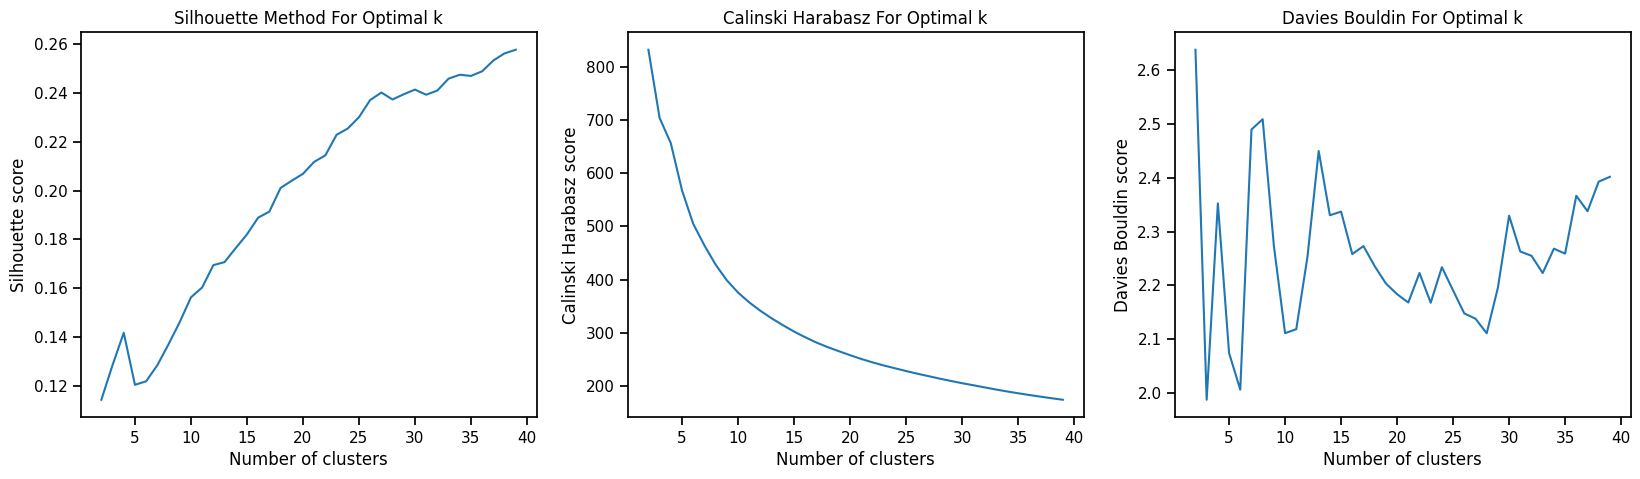

In [180]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,5))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, calinski)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski Harabasz score')
ax.set_title('Calinski Harabasz For Optimal k')

ax=axs[2]
ax.plot(K, davies)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies Bouldin score')
ax.set_title('Davies Bouldin For Optimal k')

plt.show()

In [194]:
clusters=5
model=AgglomerativeClustering(n_clusters=clusters)
model.fit(ponzi_embeddings)

AgglomerativeClustering(n_clusters=5)

In [195]:
preds = model.fit_predict(all_embeddings)

for i in range(clusters):
    tokens_seen_ponzi = []
    tokens_seen_nonponzi=[]
    for contract in all_contracts[np.where(preds==i)]:
        encoded_input = tokenizer(contract, return_tensors='pt')
        input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())
        tokens_generated = tokenizer.tokenize(contract)
        tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
        tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
        if contract in cleaned_names:
            tokens_seen_ponzi+=all_combinations(tokens_generated)
        else:
            tokens_seen_nonponzi+=all_combinations(tokens_generated)
    print('Cluster',i)
    print('Fraction Ponzi:',100*len(set(all_contracts[np.where(preds==i)]).intersection(set(cleaned_names))) / len(cleaned_names))
    print(Counter(tokens_seen_ponzi).most_common(6))
    print('Fraction Non-Ponzi:',100*len(set(all_contracts[np.where(preds==i)]).intersection(set(cleaned_names_non_ponzi))) / len(cleaned_names_non_ponzi))
    print(Counter(tokens_seen_nonponzi).most_common(6))

Cluster 0
Fraction Ponzi: 13.705583756345177
[('coin', 41), ('test', 14), ('pre', 14), ('factory', 12), ('slot', 9), ('x', 5)]
Fraction Non-Ponzi: 12.33230968159043
[('token', 450), ('coin', 68), ('sale', 60), ('withdraw', 53), ('die', 49), ('wallet', 45)]
Cluster 1
Fraction Ponzi: 20.304568527918782
[('ether', 23), ('the', 15), ('game', 12), ('pyramid', 11), ('token', 9), ('redistribution', 9)]
Fraction Non-Ponzi: 26.491029578147728
[('token', 1103), ('sale', 378), ('coin', 275), ('ale', 264), ('ether', 178), ('sal', 137)]
Cluster 2
Fraction Ponzi: 2.5380710659898478
[('ponzi', 4), ('ply', 2), ('multiply', 2), ('pixiu', 2), ('eth', 1), ('plier', 1)]
Fraction Non-Ponzi: 4.29933732018749
[('ethraffle', 13), ('ico', 11), ('iou', 10), ('sig', 9), ('ule', 7), ('hodl', 6)]
Cluster 3
Fraction Ponzi: 15.228426395939087
[('eth', 114), ('pyramid', 68), ('ponzi', 54), ('tran', 39), ('che', 39), ('double', 11)]
Fraction Non-Ponzi: 10.425084855341845
[('token', 255), ('sig', 148), ('wallet', 135),

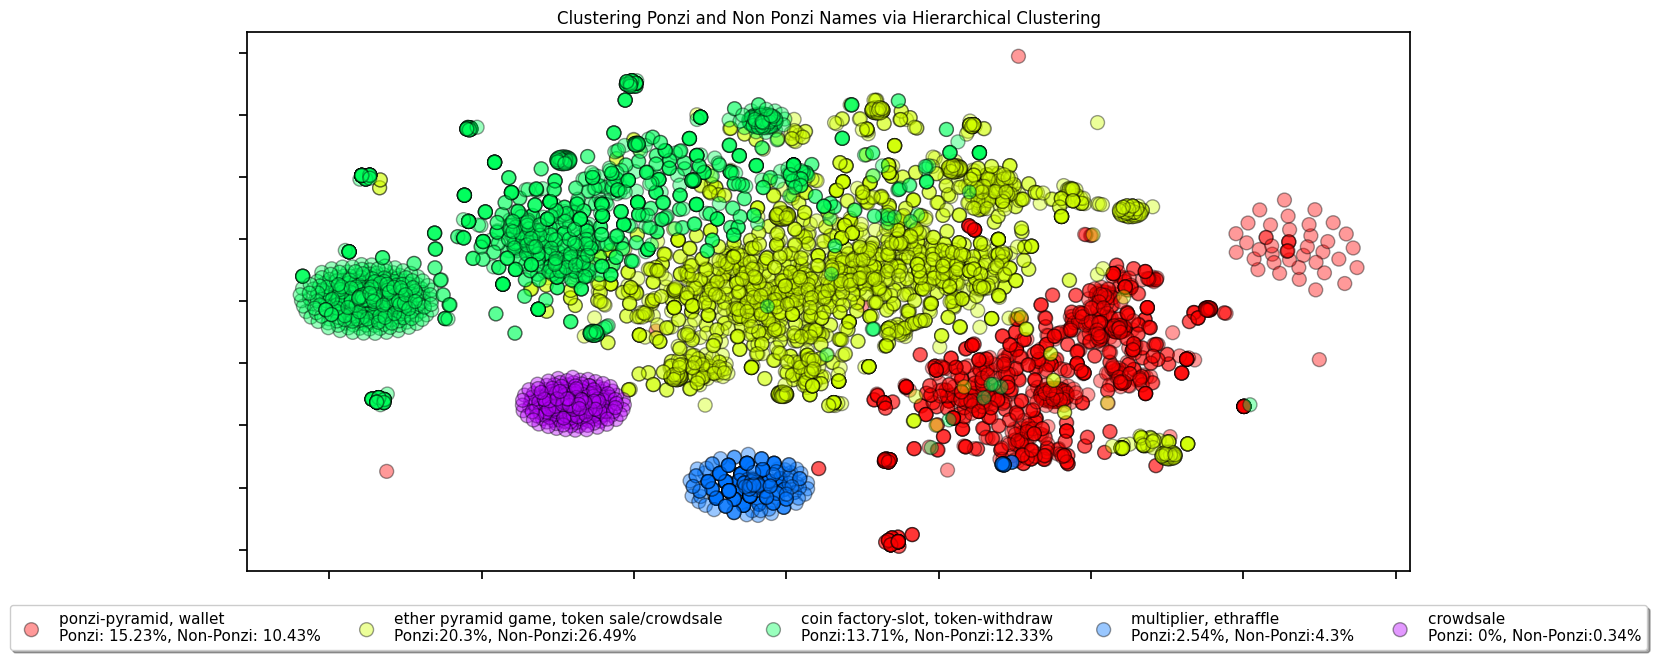

In [198]:
labels = ['coin factory-slot, token-withdraw \nPonzi:13.71%, Non-Ponzi:12.33%', 
          'ether pyramid game, token sale/crowdsale \nPonzi:20.3%, Non-Ponzi:26.49%',
          'multiplier, ethraffle \nPonzi:2.54%, Non-Ponzi:4.3%',
          'ponzi-pyramid, wallet \nPonzi: 15.23%, Non-Ponzi: 10.43%',
          'crowdsale \nPonzi: 0%, Non-Ponzi:0.34%']
labels_graph = [labels[i] for i in model.labels_]
plot_vectors(tsne, 'Clustering Ponzi and Non Ponzi Names via Hierarchical Clustering', labels_graph, dimensions=2, outside=True)

### Bayesian Gaussian Mixture

In [186]:
from sklearn.mixture import BayesianGaussianMixture
silhouettes = []
calinski = []
davies=[]

for c in tqdm(range(2, 40)):
    clustering_model =  BayesianGaussianMixture(n_components=c, random_state=1)
    preds = clustering_model.fit_predict(all_embeddings)

    silhouettes.append(silhouette_score(all_embeddings, preds))
    calinski.append(calinski_harabasz_score(all_embeddings, preds))
    davies.append(davies_bouldin_score(all_embeddings, preds))

100%|██████████| 38/38 [15:51<00:00, 25.04s/it]


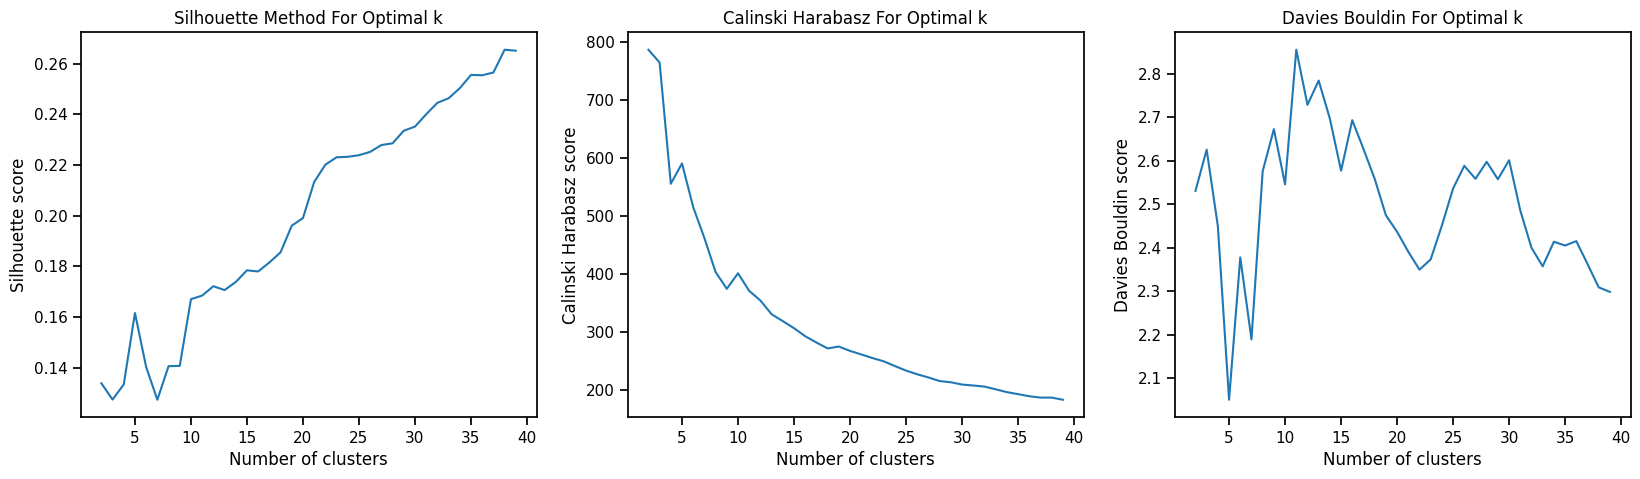

In [187]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,5))

ax=axs[0]
ax.plot(K, silhouettes)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette Method For Optimal k')

ax=axs[1]
ax.plot(K, calinski)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinski Harabasz score')
ax.set_title('Calinski Harabasz For Optimal k')

ax=axs[2]
ax.plot(K, davies)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies Bouldin score')
ax.set_title('Davies Bouldin For Optimal k')

plt.show()

In [11]:
from sklearn.mixture import BayesianGaussianMixture
clusters=5
model= BayesianGaussianMixture(n_components=clusters, random_state=1, n_init=10)
model.fit(all_embeddings)

BayesianGaussianMixture(n_components=5, n_init=10, random_state=1)

In [56]:
preds = model.predict(all_embeddings)
all_contracts_original = np.concatenate([np.array(ponzi_contracts),np.array(non_ponzi_names)], axis=0)

for i in range(clusters):
    tokens_seen_ponzi = []
    tokens_seen_nonponzi=[]
    for contract in all_contracts[np.where(preds==i)]:
        encoded_input = tokenizer(contract, return_tensors='pt')
        input_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'].squeeze().tolist())
        tokens_generated = tokenizer.tokenize(contract)
        tokens_truncated = [i[2:] for i in tokens_generated if '#' in i and '[' not in i]
        tokens_generated = [i for i in tokens_generated if '#' not in i and '[' not in i]+tokens_truncated
        if contract in cleaned_names:
            tokens_seen_ponzi+=all_combinations(tokens_generated)
        else:
            tokens_seen_nonponzi+=all_combinations(tokens_generated)
    print('Cluster',i)
    print('Fraction Ponzi:',100*len(set(all_contracts[np.where(preds==i)]).intersection(set(cleaned_names))) / len(cleaned_names))
    print(Counter(tokens_seen_ponzi).most_common(6))
    print('Fraction Non-Ponzi:',100*len(set(all_contracts[np.where(preds==i)]).intersection(set(cleaned_names_non_ponzi))) / len(cleaned_names_non_ponzi))
    print(Counter(tokens_seen_nonponzi).most_common(6))

Cluster 0
Fraction Ponzi: 0.0
[]
Fraction Non-Ponzi: 1.4708259253272993
[('ale', 415), ('sale', 77), ('sal', 75), ('token', 46), ('coin', 8), ('lif', 4)]
Cluster 1
Fraction Ponzi: 2.5380710659898478
[('ponzi', 4), ('ply', 2), ('multiply', 2), ('pixiu', 2), ('eth', 1), ('plier', 1)]
Fraction Non-Ponzi: 4.331663164700178
[('ethraffle', 13), ('ico', 11), ('iou', 10), ('sig', 10), ('ule', 7), ('hodl', 6)]
Cluster 2
Fraction Ponzi: 17.766497461928935
[('ether', 15), ('the', 13), ('game', 12), ('pyramid', 9), ('token', 9), ('redistribution', 9)]
Fraction Non-Ponzi: 25.699046387586876
[('token', 997), ('sale', 314), ('coin', 272), ('ether', 134), ('buyer', 73), ('proxy', 65)]
Cluster 3
Fraction Ponzi: 14.213197969543147
[('coin', 45), ('test', 14), ('pre', 14), ('factory', 12), ('slot', 9), ('five', 6)]
Fraction Non-Ponzi: 11.637304024567642
[('token', 448), ('coin', 67), ('withdraw', 53), ('die', 49), ('sale', 49), ('contest', 45)]
Cluster 4
Fraction Ponzi: 17.258883248730964
[('eth', 115), 

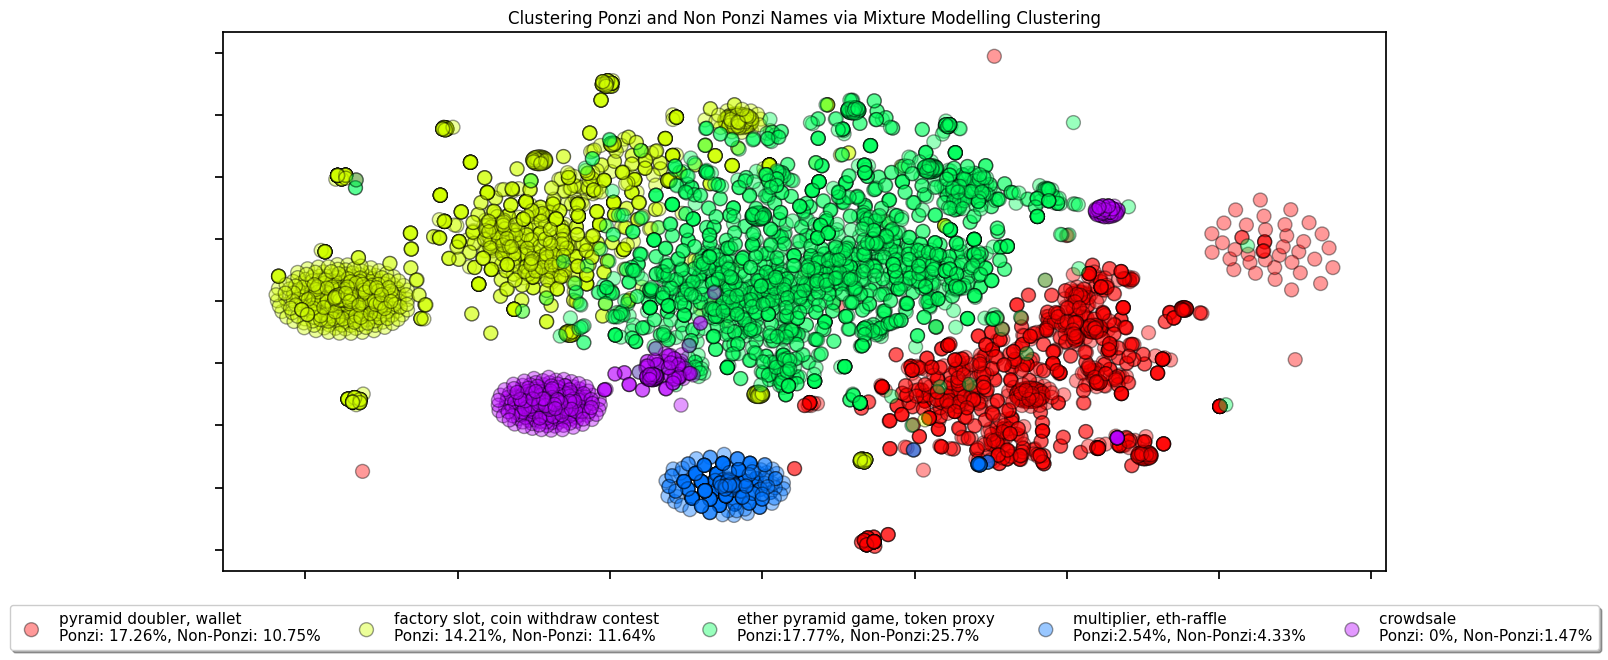

In [57]:
labels = ['crowdsale \nPonzi: 0%, Non-Ponzi:1.47%', 
          'multiplier, eth-raffle \nPonzi:2.54%, Non-Ponzi:4.33%',
          'ether pyramid game, token proxy \nPonzi:17.77%, Non-Ponzi:25.7%',
          'factory slot, coin withdraw contest \nPonzi: 14.21%, Non-Ponzi: 11.64%',
          'pyramid doubler, wallet \nPonzi: 17.26%, Non-Ponzi: 10.75%']
labels_graph = [labels[i] for i in preds]
plot_vectors(tsne, 'Clustering Ponzi and Non Ponzi Names via Mixture Modelling Clustering', labels_graph, dimensions=2, outside=True)

In [15]:
preds_names = pd.DataFrame({'contract_name':all_contracts_original, 'cluster':preds})
preds_names=preds_names.drop_duplicates()
preds_names.to_csv('Predicted_cluster.csv', index=False)